In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:


### Package to parse the fkpt code from Alejandro Aviles
import numpy as np
import sys, platform, os, subprocess
#from classy import Class

### Package to compute the multipoles and include AP test
import scipy
from scipy import integrate
from scipy import interpolate
from scipy.special import spherical_jn
from scipy.special import eval_legendre
from scipy.integrate import quad


f_kfunctions_nw='./Output/kfunctions_nw.dat'
f_kfunctions='./Output/kfunctions.dat'
f_linear_functions = './Output/linear.dat'


#########################################################################################
############################### Multipoles and AP  ##################################
#########################################################################################



def Table_interp(k, kev, Table):
    '''Cubic interpolator.
    
    Args:
        k: coordinates at which to evaluate the interpolated values.
        kev: x-coordinates of the data points.
        Table: list of 1-loop contributions for the wiggle and non-wiggle
    '''
    f = interpolate.interp1d(kev, Table, kind = 'cubic', fill_value = "extrapolate")
    Tableout = f(k) 

    return Tableout


def read_kfunctions(zout =-1):
    #print(proc)
    
    # global TableOut, TableOut_NW, kfunctions, kfunctions_NW, linear, sigma2w, sigma2w_NW, f0

    
    kfunctions = np.loadtxt(f_kfunctions, unpack=True)
    kfunctions_NW = np.loadtxt(f_kfunctions_nw, unpack=True)
    
    #linear = k, pkl, fk, D+, pkl_NW
    linear = np.loadtxt(f_linear_functions, unpack=True)
    
    
    #computing sigma2w and sigma2w_NW
    inputpkTff = (linear[0], linear[1] *  (linear[2]/linear[2][0])**2)     # (k, pkl * (fk/f0)**2 )
    inputpkTff_NW = (linear[0], linear[4] *  (linear[2]/linear[2][0])**2)  # (k, pkl_NW * (fk/f0)**2 )
    
    sigma2w = 1/(6 * np.pi**2) * scipy.integrate.simps(inputpkTff[1], inputpkTff[0])
    sigma2w_NW = 1/(6 * np.pi**2) * scipy.integrate.simps(inputpkTff_NW[1], inputpkTff_NW[0])
    
    f0 = kfunctions[29][0]
    
                
    TableOut = (kfunctions[0],                       #k
                kfunctions[27],                      #pk_l
                kfunctions[28]/kfunctions[29][0],    #Fkoverf0
                kfunctions[1] + kfunctions[4],       #Ploop_dd = P22_dd + P13_dd
                kfunctions[2] + kfunctions[5],       #Ploop_dt
                kfunctions[3] + kfunctions[6],       #Ploop_tt 
                kfunctions[19],                      #Pb1b2
                kfunctions[20],                      #Pb1bs2
                kfunctions[21],                      #Pb22
                kfunctions[22],                      #Pb2bs2
                kfunctions[23],                      #Pb2s2
                kfunctions[26],                      #sigma23pkl
                kfunctions[24],                      #Pb2t
                kfunctions[25],                      #Pbs2t
                kfunctions[7],                       #I1udd_1
                kfunctions[8],                       #I2uud_1
                kfunctions[9],                       #I2uud_2
                kfunctions[10],                      #I3uuu_2
                kfunctions[11],                      #I3uuu_3
                kfunctions[12],                      #I2uudd_1D
                kfunctions[13],                      #I2uudd_2D
                kfunctions[14],                      #I3uuud_2D
                kfunctions[15],                      #I3uuud_3D
                kfunctions[16],                      #I4uuuu_2D
                kfunctions[17],                      #I4uuuu_3D
                kfunctions[18],                      #I4uuuu_4D
                kfunctions[29],                      #f0
                sigma2w                              #sigma2w
           )
    
    
    
    TableOut_NW = (kfunctions_NW[0],                          #k
               kfunctions_NW[27],                         #pk_l_NW
               kfunctions_NW[28]/kfunctions_NW[29][0],    #Fkoverf0
               kfunctions_NW[1] + kfunctions_NW[4],       #Ploop_dd_NW
               kfunctions_NW[2] + kfunctions_NW[5],       #Ploop_dt_NW
               kfunctions_NW[3] + kfunctions_NW[6],       #Ploop_tt_NW 
               kfunctions_NW[19],                         #Pb1b2_NW
               kfunctions_NW[20],                         #Pb1bs2_NW
               kfunctions_NW[21],                         #Pb22_NW
               kfunctions_NW[22],                         #Pb2bs2_NW
               kfunctions_NW[23],                         #Pb2s2_NW
               kfunctions_NW[26],                         #sigma23pkl_NW
               kfunctions_NW[24],                         #Pb2t_NW
               kfunctions_NW[25],                         #Pbs2t_NW
               kfunctions_NW[7],                          #I1udd_1_NW
               kfunctions_NW[8],                          #I2uud_1_NW
               kfunctions_NW[9],                          #I2uud_2_NW
               kfunctions_NW[10],                         #I3uuu_2_NW
               kfunctions_NW[11],                         #I3uuu_3_NW
               kfunctions_NW[12],                         #I2uudd_1D_NW
               kfunctions_NW[13],                         #I2uudd_2D_NW
               kfunctions_NW[14],                         #I3uuud_2D_NW
               kfunctions_NW[15],                         #I3uuud_3D_NW
               kfunctions_NW[16],                         #I4uuuu_2D_NW
               kfunctions_NW[17],                         #I4uuuu_3D_NW
               kfunctions_NW[18],                         #I4uuuu_4D_NW
               kfunctions_NW[29],                         #f0
               sigma2w_NW                                 #sigma2w_NW
              )
    
    return TableOut, TableOut_NW, kfunctions, kfunctions_NW, linear, sigma2w, sigma2w_NW, f0


TableOut, TableOut_NW, kfunctions, kfunctions_NW, linear, sigma2w, sigma2w_NW, f0 = read_kfunctions(zout =-1)


def TableOut_interp(k):
    '''Interpolation of non-linear terms given by the wiggle power spectra.
    
    Args:
        k: wave-number.
    Returns:
        Interpolates the non-linear terms given by the wiggle power spectra.
    '''
    nobjects = 25
    Tableout = np.zeros((nobjects + 1, len(k)))
    for ii in range(nobjects):
        Tableout[ii][:] = Table_interp(k, TableOut[0], TableOut[1+ii])
        Tableout[25][:] = sigma2w
    return Tableout




def TableOut_NW_interp(k):
    '''Interpolation of non-linear terms given by the non-wiggle power spectra.
    
    Args:
        k: wave-number.
    Returns:
        Interpolates the non-linear terms given by the non-wiggle power spectra.
    '''
    nobjects = 25
    Tableout_NW = np.zeros((nobjects + 1, len(k)))
    for ii in range(nobjects):
        Tableout_NW[ii][:] = Table_interp(k, TableOut_NW[0], TableOut_NW[1+ii])
        Tableout_NW[25][:] = sigma2w_NW
    return Tableout_NW




def PEFTs(kev, mu, NuisanParams, Table):
    '''EFT galaxy power spectrum, Eq. ~ 3.40 at arXiv: 2208.02791.
    
    Args: 
        kev: evaluation points (wave-number coordinates).
        mu: cosine angle between the wave-vector ‘\vec{k}’ and the line-of-sight direction ‘\hat{n}’.
        NuisamParams: set of nuisance parameters [b1, b2, bs2, b3nl, alpha0, alpha2, alpha4, ctilde, 
                                                  alphashot0, alphashot2, PshotP] in that order.
                    b1, b2, bs2, b3nl: biasing parameters.
                    alpha0, alpha2, alpha4: EFT parameters.
                    ctilde: parameter for NL0 ∝ Kaiser power spectrum.
                    alphashot0, alphashot2, PshotP: stochastic noise parameters.
       Table: List of non-linear terms given by the wiggle or non-wiggle power spectra.
    Returns:
       EFT galaxy power spectrum in redshift space.
    '''
    
    #NuisanParams
    (b1, b2, bs2, b3nl, alpha0, alpha2, alpha4, 
                ctilde, alphashot0, alphashot2, PshotP) = NuisanParams
    
    #Table
    (pkl, Fkoverf0, Ploop_dd, Ploop_dt, Ploop_tt, Pb1b2, Pb1bs2, Pb22, Pb2bs2, 
         Pb2s2, sigma23pkl, Pb2t, Pbs2t, I1udd_1, I2uud_1, I2uud_2, I3uuu_2, I3uuu_3, 
         I2uudd_1D, I2uudd_2D, I3uuud_2D, I3uuud_3D, I4uuuu_2D, I4uuuu_3D, I4uuuu_4D, sigma2w) = Table
    
    fk = Fkoverf0*f0
        
    #linear power spectrum
    Pdt_L = pkl*Fkoverf0; Ptt_L = pkl*Fkoverf0**2;
        
    #one-loop power spectrum 
    Pdd = pkl + Ploop_dd; Pdt = Pdt_L + Ploop_dt; Ptt = Ptt_L + Ploop_tt;
        
        
    #biasing
    def PddXloop(b1, b2, bs2, b3nl):
        return (b1**2 * Ploop_dd + 2*b1*b2*Pb1b2 + 2*b1*bs2*Pb1bs2 + b2**2 * Pb22
                   + 2*b2*bs2*Pb2bs2 + bs2**2 *Pb2s2 + 2*b1*b3nl*sigma23pkl)
        
    def PdtXloop(b1, b2, bs2, b3nl):
        return b1*Ploop_dt + b2*Pb2t + bs2*Pbs2t + b3nl*Fkoverf0*sigma23pkl
        
    def PttXloop(b1, b2, bs2, b3nl):
        return Ploop_tt
        
    #RSD functions       
    def Af(mu, f0):
        return (f0*mu**2 * I1udd_1 + f0**2 * (mu**2 * I2uud_1 + mu**4 * I2uud_2)
                    + f0**3 * (mu**4 * I3uuu_2 +  mu**6 * I3uuu_3)) 
        
    def Df(mu, f0):
        return (f0**2 * (mu**2 * I2uudd_1D + mu**4 * I2uudd_2D) 
                    + f0**3 * (mu**4 * I3uuud_2D + mu**6 * I3uuud_3D)
                    + f0**4 * (mu**4 * I4uuuu_2D + mu**6 * I4uuuu_3D + mu**8 * I4uuuu_4D))
        
        
    #Introducing bias in RSD functions, eq.~ A.32 & A.33 at arXiv: 2208.02791
    def ATNS(mu, b1):
        return b1**3 * Af(mu, f0/b1)
        
    def DRSD(mu, b1):
        return b1**4 * Df(mu, f0/b1)
    
    #fixed to zero: fkpt used D = A + B - G; (G's are already subtracted on D terms)
    def GTNS(mu, b1):
        return 0.0 
        
        
    #One-loop SPT power spectrum in redshift space
    def PloopSPTs(mu, b1, b2, bs2, b3nl):
        return (PddXloop(b1, b2, bs2, b3nl) + 2*f0*mu**2 * PdtXloop(b1, b2, bs2, b3nl)
                    + mu**4 * f0**2 * PttXloop(b1, b2, bs2, b3nl) + ATNS(mu, b1) + DRSD(mu, b1)
                    + GTNS(mu, b1))
        
        
    #Linear Kaiser power spectrum
    def PKaiserLs(mu, b1):
        return (b1 + mu**2 * fk)**2 * pkl
        
    def PctNLOs(mu, b1, ctilde):
        return ctilde*(mu*kev*f0)**4 * sigma2w**2 * PKaiserLs(mu, b1)
    
    # EFT counterterms
    def Pcts(mu, alpha0, alpha2, alpha4):
        return (alpha0 + alpha2 * mu**2 + alpha4 * mu**4)*kev**2 * pkl
    
    #Stochastics noise
    def Pshot(mu, alphashot0, alphashot2, PshotP):
        return PshotP*(alphashot0 + alphashot2 * (kev*mu)**2)
        
    return (PloopSPTs(mu, b1, b2, bs2, b3nl) + Pcts(mu, alpha0, alpha2, alpha4)
                + PctNLOs(mu, b1, ctilde) + Pshot(mu, alphashot0, alphashot2, PshotP))




def Sigma2Total(kev, mu, Table_NW):
    '''Sigma² tot for IR-resummations, see eq.~ 3.59 at arXiv:2208.02791
    
    Args:
        kev: evaluation points (wave-number coordinates). 
        mu: cosine angle between the wave-vector ‘\vec{k}’ and the line-of-sight direction ‘\hat{n}’.
        Table_NW: List of non-linear terms given by the non-wiggle power spectra.
    Returns:
        Sigma² tot for IR-resummations.
    '''
    kT = kev; pkl_NW = Table_NW[0];
        
    kinit = 10**(-6);  kS = 0.4;                                  #integration limits
    pT = np.logspace(np.log10(kinit),np.log10(kS), num = 10**2)   #integration range
        
    PSL_NW = Table_interp(pT, kT, pkl_NW)
    k_BAO = 1/104                                                 #BAO scale
        
    Sigma2 = 1/(6 * np.pi**2)*scipy.integrate.simps(PSL_NW*(1 - spherical_jn(0, pT/k_BAO) 
                                                + 2*spherical_jn(2, pT/k_BAO)), pT)
        
    deltaSigma2 = 1/(2 * np.pi**2)*scipy.integrate.simps(PSL_NW*spherical_jn(2, pT/k_BAO), pT)
        
    def Sigma2T(mu):
        return (1 + f0*mu**2 *(2 + f0))*Sigma2 + (f0*mu)**2 * (mu**2 - 1)* deltaSigma2
        
    return Sigma2T(mu)




def k_AP(k_obs, mu_obs, qperp, qpar):
    '''True ‘k’ coordinates.
    
    Args: where ‘_obs’ denote quantities that are observed assuming the reference (fiducial) cosmology.
        k_obs: observed wave-number.
        mu_obs: observed cosine angle between the wave-vector ‘\vec{k}’ and the line-of-sight direction ‘\hat{n}’.
        qperp, qpar: AP parameters.
    Returns:
        True wave-number ‘k_AP’.
    '''
    F = qpar/qperp
    return (k_obs/qperp)*(1 + mu_obs**2 * (1./F**2 - 1))**(0.5)




def mu_AP(mu_obs, qperp, qpar):
    '''True ‘mu’ coordinates.
    
    Args: where ‘_obs’ denote quantities that are observed assuming the reference (fiducial) cosmology.
        mu_obs: observed cosine angle between the wave-vector ‘\vec{k}’ and the line-of-sight direction ‘\hat{n}’.
        qperp, qpar: AP parameters.
    Returns:
        True ‘mu_AP’.
    '''
    F = qpar/qperp
    return (mu_obs/F) * (1 + mu_obs**2 * (1/F**2 - 1))**(-0.5)




def Hubble(Om, z_ev):
    '''Hubble parameter.
    
    Args:
        Om: Omega_b + Omega_c + Omega_nu (dimensionless matter density parameter).
        z_ev: redshift of evaluation.
    Returns:
        Hubble parameter.
    '''
    return ((Om) * (1 + z_ev)**3. + (1 - Om))**0.5




def DA(Om, z_ev):
    '''Angular-diameter distance.
    
     Args:
        Om: Omega_b + Omega_c + Omega_nu (dimensionless matter density parameter).
        z_ev: redshift of evaluation.
    Returns:
        Angular diameter distance.
    '''
    r = quad(lambda x: 1. / Hubble(Om, x), 0, z_ev)[0]
    return r / (1 + z_ev)




def RSDmultipoles(kev, NuisanParams, z_pk, OmM = -1, Omfid = -1, AP = False):
    '''Redshift space power spectrum multipoles.
    
    Args:
        If 'AP=True' (default: 'False') the code perform the AP test.
        If 'AP=True'. Include the fiducial Omfid after ‘NuisanParams’.
        
        kev: wave-number coordinates of evaluation.
        NuisamParams: set of nuisance parameters [b1, b2, bs2, b3nl, alpha0, alpha2, alpha4, ctilde, alphashot0, 
                                                  alphashot2, PshotP] in that order.
                   b1, b2, bs2, b3nl: biasing parameters.
                   alpha0, alpha2, alpha4: EFT parameters.
                   ctilde: parameter for NL0 ∝ Kaiser power spectrum.
                   alphashot0, alphashot2, PshotP: stochastic noise parameters.
    Returns:
       Redshift space power spectrum multipoles (monopole, quadrupole and hexadecapole) at 'kev'.
    '''
            
    #NuisanParams
    (b1, b2, bs2, b3nl, alpha0, alpha2, alpha4, 
                ctilde, alphashot0, alphashot2, PshotP) = NuisanParams
    
    if AP == True and OmM < 0 and Omfid < 0:
        sys.exit("Introduce the value for the matter density parameter (Omega_M) associated with the input linear power spectrum, using ‘OmM = value’. \n Introduce the fiducial value of the dimensionless matter density parameter as ‘Omfid = value’. ")
        
            
    if AP == True and OmM < 0:
        sys.exit("Introduce the value for the matter density parameter (Omega_M) associated with the input linear power spectrum, using ‘OmM = value’.")
    
    if AP == True and Omfid < 0:
        sys.exit("Introduce the fiducial value of the dimensionless matter density parameter as ‘Omfid = value’.")
     
    if AP == True and Omfid > 0 and OmM > 0:
                
        #Om computed for any cosmology -> obtained from 'genarate_ps'
        ###OmM = CosmoParam(h, omega_b, omega_cdm, omega_ncdm)[1]
        
        #qperp, qpar: AP parameters.
        qperp = DA(OmM, z_pk)/DA(Omfid, z_pk) 
        qpar = Hubble(Omfid, z_pk)/Hubble(OmM, z_pk) 
        
        
    def PIRs(kev, mu, Table, Table_NW):
        
        if AP == True:
            
            k_true = k_AP(kev, mu, qperp, qpar)
            mu_true = mu_AP(mu, qperp, qpar)
            
            Table_true = Table_interp(k_true, kev, Table)
            Table_NW_true = Table_interp(k_true, kev, Table_NW)
            
            Sigma2T = Sigma2Total(k_true, mu_true, Table_NW_true)
            
            Fkoverf0 = Table_true[1]; fk = Fkoverf0*f0
            pkl = Table_true[0]; pkl_NW = Table_NW_true[0];
            
            
            return ((b1 + fk * mu_true**2)**2 * (pkl_NW + np.exp(-k_true**2 * Sigma2T)*(pkl-pkl_NW)*(1 + k_true**2 * Sigma2T) )
                + np.exp(-k_true**2 * Sigma2T)*PEFTs(k_true, mu_true, NuisanParams, Table_true) 
                + (1 - np.exp(-k_true**2 * Sigma2T))*PEFTs(k_true, mu_true, NuisanParams, Table_NW_true)) 
            
        else:
            
            k = kev; Fkoverf0 = Table[1]; fk = Fkoverf0*f0
            pkl = Table[0]; pkl_NW = Table_NW[0];
            Sigma2T = Sigma2Total(kev, mu, Table_NW)
            
            return ((b1 + fk * mu**2)**2 * (pkl_NW + np.exp(-k**2 * Sigma2T)*(pkl-pkl_NW)*(1 + k**2 * Sigma2T) )
                + np.exp(-k**2 * Sigma2T)*PEFTs(k, mu, NuisanParams, Table) 
                + (1 - np.exp(-k**2 * Sigma2T))*PEFTs(k, mu, NuisanParams, Table_NW))     
    
    
    if AP == True:
        
        Nx = 6                                         #Points
        xGL, wGL = scipy.special.roots_legendre(Nx)    #x=cosθ and weights
        
        def ModelPkl0(Table, Table_NW):
            monop = 0;
            for ii in range(Nx):
                monop = monop + 0.5/(qperp**2 * qpar)*wGL[ii]*PIRs(kev, xGL[ii], Table, Table_NW)
            return monop
        
        def ModelPkl2(Table, Table_NW):    
            quadrup = 0;
            for ii in range(Nx):
                quadrup = quadrup + 5/(2*qperp**2 * qpar)*wGL[ii]*PIRs(kev, xGL[ii], Table, Table_NW)*eval_legendre(2, xGL[ii])
            return quadrup
        
        def ModelPkl4(Table, Table_NW):
            hexadecap = 0;
            for ii in range(Nx):
                hexadecap = hexadecap + 9/(2*qperp**2 * qpar)*wGL[ii]*PIRs(kev, xGL[ii], Table, Table_NW)*eval_legendre(4, xGL[ii])
            return hexadecap
    
    else:
        
        Nx = 6                                         #Points
        xGL, wGL = scipy.special.roots_legendre(Nx)    #x=cosθ and weights
        
        def ModelPkl0(Table, Table_NW):
            monop = 0;
            for ii in range(Nx):
                monop = monop + 0.5*wGL[ii]*PIRs(kev, xGL[ii], Table, Table_NW)
            return monop
        
        def ModelPkl2(Table, Table_NW):    
            quadrup = 0;
            for ii in range(Nx):
                quadrup = quadrup + 5/2*wGL[ii]*PIRs(kev, xGL[ii], Table, Table_NW)*eval_legendre(2, xGL[ii])
            return quadrup
        
        def ModelPkl4(Table, Table_NW):
            hexadecap = 0;
            for ii in range(Nx):
                hexadecap = hexadecap + 9/2*wGL[ii]*PIRs(kev, xGL[ii], Table, Table_NW)*eval_legendre(4, xGL[ii])
            return hexadecap
        
    
    Pkl0 = ModelPkl0(TableOut_interp(kev), TableOut_NW_interp(kev));
    Pkl2 = ModelPkl2(TableOut_interp(kev), TableOut_NW_interp(kev));
    Pkl4 = ModelPkl4(TableOut_interp(kev), TableOut_NW_interp(kev));

    
    return (kev, Pkl0, Pkl2, Pkl4)



In [2]:
b1, b2, bs2, b3nl=2,0.2,0.2,0
alpha0_gm, alpha2_gm, alpha4_gm = 0,0,0
ctilde_gm, alphashot0_gm, alphashot2_gm, PshotP_gm = 0,0,0,0
NuisanParams_gm = [b1, b2, bs2, b3nl, alpha0_gm, alpha2_gm, alpha4_gm, 
                ctilde_gm, alphashot0_gm, alphashot2_gm, PshotP_gm]


kev_=np.linspace(0.01, 0.3,60)
kT,p0,p2,p4=RSDmultipoles(kev_,NuisanParams_gm,z_pk=0.5)

In [3]:

kev_=np.linspace(0.01, 0.3,60)
kT,p0,p2,p4=RSDmultipoles(kev_,NuisanParams_gm,z_pk=0.5)

In [4]:
np.linspace(0.01, 0.3,60)

array([0.01      , 0.01491525, 0.01983051, 0.02474576, 0.02966102,
       0.03457627, 0.03949153, 0.04440678, 0.04932203, 0.05423729,
       0.05915254, 0.0640678 , 0.06898305, 0.07389831, 0.07881356,
       0.08372881, 0.08864407, 0.09355932, 0.09847458, 0.10338983,
       0.10830508, 0.11322034, 0.11813559, 0.12305085, 0.1279661 ,
       0.13288136, 0.13779661, 0.14271186, 0.14762712, 0.15254237,
       0.15745763, 0.16237288, 0.16728814, 0.17220339, 0.17711864,
       0.1820339 , 0.18694915, 0.19186441, 0.19677966, 0.20169492,
       0.20661017, 0.21152542, 0.21644068, 0.22135593, 0.22627119,
       0.23118644, 0.23610169, 0.24101695, 0.2459322 , 0.25084746,
       0.25576271, 0.26067797, 0.26559322, 0.27050847, 0.27542373,
       0.28033898, 0.28525424, 0.29016949, 0.29508475, 0.3       ])

In [5]:

def Pgm(kev, mu, NuisanParams_gm, Table):
    '''EFT galaxy power spectrum, Eq. ~ 3.40 at arXiv: 2208.02791.
    
    Args: 
        kev: evaluation points (wave-number coordinates).
        mu: cosine angle between the wave-vector ‘\vec{k}’ and the line-of-sight direction ‘\hat{n}’.
        NuisamParams: set of nuisance parameters [b1, b2, bs2, b3nl, alpha0, alpha2, alpha4, ctilde, 
                                                  alphashot0, alphashot2, PshotP] in that order.
                    b1, b2, bs2, b3nl: biasing parameters.
                    alpha0, alpha2, alpha4: EFT parameters.
                    ctilde: parameter for NL0 ∝ Kaiser power spectrum.
                    alphashot0, alphashot2, PshotP: stochastic noise parameters.
       Table: List of non-linear terms given by the wiggle or non-wiggle power spectra.
    Returns:
       EFT galaxy power spectrum in redshift space.
    '''
    
    #NuisanParams
    (b1, b2, bs2, b3nl, alpha0, alpha2, alpha4, 
                ctilde, alphashot0, alphashot2, PshotP) = NuisanParams_gm
    
    #Table
    (pkl, Fkoverf0, Ploop_dd, Ploop_dt, Ploop_tt, Pb1b2, Pb1bs2, Pb22, Pb2bs2, 
         Pb2s2, sigma23pkl, Pb2t, Pbs2t, I1udd_1, I2uud_1, I2uud_2, I3uuu_2, I3uuu_3, 
         I2uudd_1D, I2uudd_2D, I3uuud_2D, I3uuud_3D, I4uuuu_2D, I4uuuu_3D, I4uuuu_4D, sigma2w) = Table
    
    fk = Fkoverf0*f0
        
    #linear power spectrum
    Pdt_L = pkl*Fkoverf0; Ptt_L = pkl*Fkoverf0**2;
        
    #one-loop power spectrum 
    Pdd = pkl + Ploop_dd; Pdt = Pdt_L + Ploop_dt; Ptt = Ptt_L + Ploop_tt;
        
    #biasing
    def P_dX_dm_loop(b1, b2, bs2, b3nl):
        return (b1 * Ploop_dd + b2*Pb1b2 + bs2*Pb1bs2 + b3nl*sigma23pkl)
        
    def P_dm_tX_loop(b1, b2, bs2, b3nl):
        return Ploop_dt
        
    def P_tm_tX_loop(b1, b2, bs2, b3nl):
        return Ploop_tt
        
       
    def Amg_b12(mu, f0):
        mu2=mu**2
        return (0.5*f0*mu2 * I1udd_1 + f0**2 * mu2 * (I2uud_1 + mu2 * I2uud_2))  

    def Amg_b13(mu, f0):
        return  f0**3 * (mu**4 * I3uuu_2 +  mu**6 * I3uuu_3) 
        
    def Dmg_f(mu, f0):
        return (f0**2 * (mu**2 * I2uudd_1D + mu**4 * I2uudd_2D) 
                    + f0**3 * (mu**4 * I3uuud_2D + mu**6 * I3uuud_3D)
                    + f0**4 * (mu**4 * I4uuuu_2D + mu**6 * I4uuuu_3D + mu**8 * I4uuuu_4D))
        
        
    #Introducing bias in RSD functions, eq.~ A.32 & A.33 at arXiv: 2208.02791
    def ATNS(mu, b1):
        return b1**2 * Amg_b12(mu, f0/b1) +  b1**3 * Amg_b13(mu, f0/b1)
        
    def DRSD(mu, b1):
        return b1**2 * Dmg_f(mu, f0/b1)
    
    #fixed to zero: fkpt used D = A + B - G; (G's are already subtracted on D terms)
    def GTNS(mu, b1):
        return 0.0 
        
        
    #One-loop SPT power spectrum in redshift space
    def PloopSPTs(mu, b1, b2, bs2, b3nl):
        return (P_dX_dm_loop(b1, b2, bs2, b3nl) + f0*mu**2 * (P_dm_tX_loop(b1, b2, bs2, b3nl) + P_dX_dm_loop(b1, b2, bs2, b3nl))
                    + mu**4 * f0**2 * P_tm_tX_loop(b1, b2, bs2, b3nl) + ATNS(mu, b1) + DRSD(mu, b1)
                    + GTNS(mu, b1))
        
        
    #Linear Kaiser power spectrum
    def PKaiserLs(mu, b1):
        return (b1 + mu**2 * fk)*(1 + mu**2 * fk) * pkl
        
    def PctNLOs(mu, b1, ctilde_gm):
        return ctilde_gm*(mu*kev*f0)**4 * sigma2w**2 * PKaiserLs(mu, b1)
    
    # EFT counterterms
    def Pcts(mu, alpha0mg, alpha2mg, alpha4mg):
        return (alpha0_gm + alpha2_gm * mu**2 + alpha4_gm * mu**4)*kev**2 * pkl
    
    #Stochastics noise
    def Pshot(mu, alphashot0_gm, alphashot2_gm, PshotP_gm):
        return PshotP_gm*(alphashot0_gm + alphashot2_gm * (kev*mu)**2)

    output = PloopSPTs(mu, b1, b2, bs2, b3nl) + Pcts(mu, alpha0_gm, alpha2_gm, alpha4_gm) + PctNLOs(mu, b1, ctilde_gm) + Pshot(mu, alphashot0_gm, alphashot2_gm, PshotP_gm)

    
    return output




def RSDmultipoles_gm(kev, NuisanParams, z_pk, OmM = -1, Omfid = -1, AP = False):
    '''Redshift space power spectrum multipoles.
    
    Args:
        If 'AP=True' (default: 'False') the code perform the AP test.
        If 'AP=True'. Include the fiducial Omfid after ‘NuisanParams’.
        
        kev: wave-number coordinates of evaluation.
        NuisamParams: set of nuisance parameters [b1, b2, bs2, b3nl, alpha0, alpha2, alpha4, ctilde, alphashot0, 
                                                  alphashot2, PshotP] in that order.
                   b1, b2, bs2, b3nl: biasing parameters.
                   alpha0, alpha2, alpha4: EFT parameters.
                   ctilde: parameter for NL0 ∝ Kaiser power spectrum.
                   alphashot0, alphashot2, PshotP: stochastic noise parameters.
    Returns:
       Redshift space power spectrum multipoles (monopole, quadrupole and hexadecapole) at 'kev'.
    '''
            

    
    (b1, b2, bs2, b3nl, alpha0, alpha2, alpha4, 
                ctilde, alphashot0, alphashot2, PshotP) = NuisanParams
    
    if AP == True and OmM < 0 and Omfid < 0:
        sys.exit("Introduce the value for the matter density parameter (Omega_M) associated with the input linear power spectrum, using ‘OmM = value’. \n Introduce the fiducial value of the dimensionless matter density parameter as ‘Omfid = value’. ")
        
            
    if AP == True and OmM < 0:
        sys.exit("Introduce the value for the matter density parameter (Omega_M) associated with the input linear power spectrum, using ‘OmM = value’.")
    
    if AP == True and Omfid < 0:
        sys.exit("Introduce the fiducial value of the dimensionless matter density parameter as ‘Omfid = value’.")
     
    if AP == True and Omfid > 0 and OmM > 0:
                
        #Om computed for any cosmology -> obtained from 'genarate_ps'
        ###OmM = CosmoParam(h, omega_b, omega_cdm, omega_ncdm)[1]
        
        #qperp, qpar: AP parameters.
        qperp = DA(OmM, z_pk)/DA(Omfid, z_pk) 
        qpar = Hubble(Omfid, z_pk)/Hubble(OmM, z_pk) 
        
        
    def PIRs(kev, mu, Table, Table_NW):
        
        if AP == True:
            
            k_true = k_AP(kev, mu, qperp, qpar)
            mu_true = mu_AP(mu, qperp, qpar)
            
            Table_true = Table_interp(k_true, kev, Table)
            Table_NW_true = Table_interp(k_true, kev, Table_NW)
            
            Sigma2T = Sigma2Total(k_true, mu_true, Table_NW_true)
            
            Fkoverf0 = Table_true[1]; fk = Fkoverf0*f0
            pkl = Table_true[0]; pkl_NW = Table_NW_true[0];
            
            
            return ((b1 + fk * mu_true**2)*(1 + fk * mu_true**2) * (pkl_NW + np.exp(-k_true**2 * Sigma2T)*(pkl-pkl_NW)*(1 + k_true**2 * Sigma2T) )
                + np.exp(-k_true**2 * Sigma2T)*Pgm(k_true, mu_true, NuisanParams, Table_true) 
                + (1 - np.exp(-k_true**2 * Sigma2T))*Pgm(k_true, mu_true, NuisanParams, Table_NW_true)) 
            
        else:
            
            k = kev; Fkoverf0 = Table[1]; fk = Fkoverf0*f0
            pkl = Table[0]; pkl_NW = Table_NW[0];
            Sigma2T = Sigma2Total(kev, mu, Table_NW)
            
            return ((b1 + fk * mu**2)*(1 + fk * mu**2) * (pkl_NW + np.exp(-k**2 * Sigma2T)*(pkl-pkl_NW)*(1 + k**2 * Sigma2T) )
                + np.exp(-k**2 * Sigma2T)*Pgm(k, mu, NuisanParams, Table) 
                + (1 - np.exp(-k**2 * Sigma2T))*Pgm(k, mu, NuisanParams, Table_NW))     
    
    
    if AP == True:
        
        Nx = 6                                         #Points
        xGL, wGL = scipy.special.roots_legendre(Nx)    #x=cosθ and weights
        
        def ModelPkl0(Table, Table_NW):
            monop = 0;
            for ii in range(Nx):
                monop = monop + 0.5/(qperp**2 * qpar)*wGL[ii]*PIRs(kev, xGL[ii], Table, Table_NW)
            return monop
        
        def ModelPkl2(Table, Table_NW):    
            quadrup = 0;
            for ii in range(Nx):
                quadrup = quadrup + 5/(2*qperp**2 * qpar)*wGL[ii]*PIRs(kev, xGL[ii], Table, Table_NW)*eval_legendre(2, xGL[ii])
            return quadrup
        
        def ModelPkl4(Table, Table_NW):
            hexadecap = 0;
            for ii in range(Nx):
                hexadecap = hexadecap + 9/(2*qperp**2 * qpar)*wGL[ii]*PIRs(kev, xGL[ii], Table, Table_NW)*eval_legendre(4, xGL[ii])
            return hexadecap
    
    else:
        
        Nx = 6                                         #Points
        xGL, wGL = scipy.special.roots_legendre(Nx)    #x=cosθ and weights
        
        def ModelPkl0(Table, Table_NW):
            monop = 0;
            for ii in range(Nx):
                monop = monop + 0.5*wGL[ii]*PIRs(kev, xGL[ii], Table, Table_NW)
            return monop
        
        def ModelPkl2(Table, Table_NW):    
            quadrup = 0;
            for ii in range(Nx):
                quadrup = quadrup + 5/2*wGL[ii]*PIRs(kev, xGL[ii], Table, Table_NW)*eval_legendre(2, xGL[ii])
            return quadrup
        
        def ModelPkl4(Table, Table_NW):
            hexadecap = 0;
            for ii in range(Nx):
                hexadecap = hexadecap + 9/2*wGL[ii]*PIRs(kev, xGL[ii], Table, Table_NW)*eval_legendre(4, xGL[ii])
            return hexadecap
        
    
    Pkl0 = ModelPkl0(TableOut_interp(kev), TableOut_NW_interp(kev));
    Pkl2 = ModelPkl2(TableOut_interp(kev), TableOut_NW_interp(kev));
    Pkl4 = ModelPkl4(TableOut_interp(kev), TableOut_NW_interp(kev));

    
    return (kev, Pkl0, Pkl2, Pkl4)


In [6]:
b1, b2, bs2, b3nl=2,0.2,0.2,0
alpha0_gm, alpha2_gm, alpha4_gm = 0,0,0
ctilde_gm, alphashot0_gm, alphashot2_gm, PshotP_gm = 0,0,0,0
NuisanParams_gm = [b1, b2, bs2, b3nl, alpha0_gm, alpha2_gm, alpha4_gm, 
                ctilde_gm, alphashot0_gm, alphashot2_gm, PshotP_gm]
NuisanParams = NuisanParams_gm


kev_=np.linspace(0.01, 0.3,60)
kT,p0,p2,p4=RSDmultipoles(kev_,NuisanParams,z_pk=0.5)
kT_gm,p0_gm,p2_gm,p4_gm=RSDmultipoles_gm(kev_,NuisanParams_gm,z_pk=0.5)

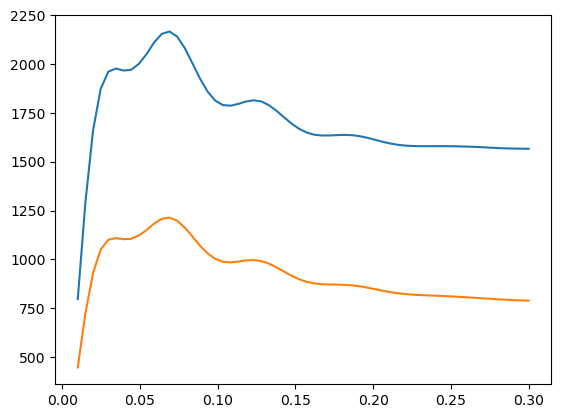

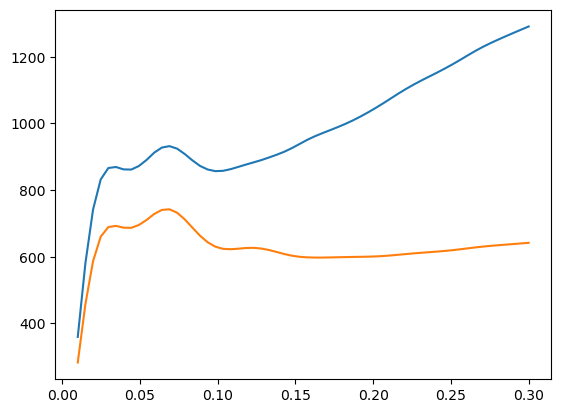

In [8]:
import matplotlib
import matplotlib.pyplot as plt

plt.plot(kT,kT*p0)
plt.plot(kT,kT*p0_gm)
plt.show()

plt.plot(kT,kT*p2)
plt.plot(kT,kT*p2_gm)
plt.show()